%%capture
%%bash
pip install captum
pip install flask_compress
conda install freetype=2.10.4

In [14]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/first_visualization_test')

In [15]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature
import matplotlib.pyplot as plt
import numpy as np
import time

In [16]:
if torch.cuda.is_available(): # use gpu if possible
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [17]:
epochs = 4000
batch_size = 400
learning_rate = 0.00015

# only need resize so AlexNet works
train_transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomAffine(0, (0.1, 0.1)),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

test_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

In [18]:
# get training/test data from CIFAR10 dataset
train_data = torchvision.datasets.CIFAR10(root = "./dataset/train",
                                        train = True, 
                                        transform = train_transform, 
                                        download = True)
test_data = torchvision.datasets.CIFAR10(root = "./dataset/test",
                                       train = False, 
                                       transform = test_transform, 
                                       download = True)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                           batch_size = batch_size, 
                                           shuffle = True, 
                                           num_workers = 3)
test_loader = torch.utils.data.DataLoader(dataset = test_data, 
                                          batch_size = batch_size, 
                                          shuffle = False, 
                                          num_workers = 3)

In [20]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 128, 3, 1)
    self.conv2 = nn.Conv2d(128, 128, 3, 1, padding=2)
    self.conv3 = nn.Conv2d(128, 128, 3, 1, padding=2)
    self.conv4 = nn.Conv2d(128, 128, 3, 1, padding=1)
    self.conv5 = nn.Conv2d(128, 128, 3, 1, padding=1)
    self.conv6 = nn.Conv2d(128, 128, 3, 1)
    self.conv7 = nn.Conv2d(128, 256, 3, 1)

    self.maxPool = nn.MaxPool2d(2, 2)

    self.drop1 = nn.Dropout(0.3)
    self.drop2 = nn.Dropout(0.3)
    self.drop3 = nn.Dropout(0.2)
    self.drop4 = nn.Dropout(0.4)

    self.BN1 = nn.BatchNorm2d(128)
    self.BN2 = nn.BatchNorm2d(128)
    self.BN3 = nn.BatchNorm2d(128)

    self.fc1 = nn.Linear(256, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)
  
  def forward(self, x):
    x = nn.functional.rrelu(self.conv1(x))
    x = self.maxPool(x)
    x = self.drop1(x)
    x = nn.functional.rrelu(self.conv2(x))
    x = self.maxPool(x)
    x = self.drop2(x)

    x = self.BN1(x)

    x = nn.functional.rrelu(self.conv3(x))

    x = nn.functional.rrelu(self.conv4(x))
    x = self.maxPool(x)
    x = self.drop3(x)

    x = nn.functional.rrelu(self.conv5(x))
    x = self.BN2(x)
    x = nn.functional.rrelu(self.conv6(x))
    x = self.drop4(x)
  # x = self.BN3(x)

    x = nn.functional.rrelu(self.conv7(x))

    x = x.reshape(x.shape[0], -1)
    #print(x.shape)
    x = nn.functional.rrelu(self.fc1(x))
    x = nn.functional.rrelu(self.fc2(x))
    x = self.fc3(x)
    return x
  

In [21]:
# Model creation

model_copy = CNN()
model = CNN().to(device)

In [22]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    try:
      npimg = img.numpy()
    except:
      npimg = img.cpu().data.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [23]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().data.numpy())
    return preds, [nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            train_data.classes[preds[idx]],
            probs[idx] * 100.0,
            train_data.classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


In [24]:
def test():
  print("Testing")
  with torch.no_grad():
    correct = 0
    samples = 0

    for (images, labels) in test_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predictions = outputs.max(1)

      samples += labels.size(0)
      correct += (predictions == labels).sum()

    print("Test accuracy was",100*float(correct)/float(samples))
    print()

In [25]:
## Training

# try other loss functions/optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=0.0015)

test_per_epoch = True
train_for_time = 0 # how many minutes to train for (and then finish current epoch)

if train_for_time:
  epochs = train_for_time*1000
start = time.time()

for epoch in range(epochs):
  print("Training")
  epoch_loss = 0
  previous_loss = 0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    # forwards
    outputs = model(images)
    loss = criterion(outputs, labels)

    # backwards
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

    # if i % 1000 == 999:    # every 1000 mini-batches...
    #
    #         # ...log the running loss
    #         writer.add_scalar('training loss',
    #                         epoch_loss-previous_loss / 1000,
    #                         epoch * len(train_loader) + i)
    #
    #         # ...log a Matplotlib Figure showing the model's predictions on a
    #         # random mini-batch
    #         writer.add_figure('predictions vs. actuals',
    #                         plot_classes_preds(model, images, labels),
    #                         global_step=epoch * len(train_loader) + i)
    #         previous_loss = epoch_loss
  
  print("Epoch", epoch+1, "complete")
  print("Loss was", epoch_loss/len(train_loader))
  print()
  if epoch%10 == 0:
    test()
  
  if train_for_time and time.time()-start >= train_for_time*60:
    break

if not test_per_epoch:
  test()

Training
Epoch 1 complete
Loss was 1.8043572006225586

Testing
Test accuracy was 43.84

Training
Epoch 2 complete
Loss was 1.4276155281066893

Training
Epoch 3 complete
Loss was 1.2650232105255126

Training
Epoch 4 complete
Loss was 1.1444818325042725

Training
Epoch 5 complete
Loss was 1.03894819355011

Training
Epoch 6 complete
Loss was 0.9596415576934815

Training
Epoch 7 complete
Loss was 0.9035965647697449

Training
Epoch 8 complete
Loss was 0.850675518989563

Training
Epoch 9 complete
Loss was 0.809143618106842

Training
Epoch 10 complete
Loss was 0.7796392693519593

Training
Epoch 11 complete
Loss was 0.7507971234321594

Testing
Test accuracy was 74.15

Training
Epoch 12 complete
Loss was 0.7274836087226868

Training
Epoch 13 complete
Loss was 0.704644124507904

Training
Epoch 14 complete
Loss was 0.6763110361099243

Training
Epoch 15 complete
Loss was 0.6612437267303467

Training
Epoch 16 complete
Loss was 0.6552680625915527

Training
Epoch 17 complete
Loss was 0.63054936647415

KeyboardInterrupt: 

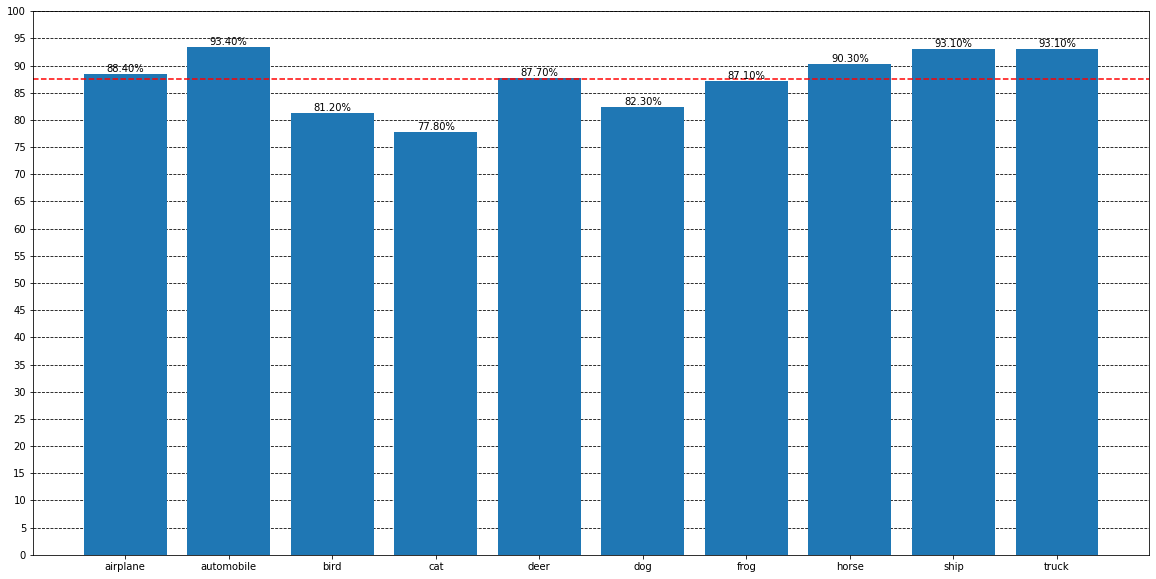

TypeError: __init__() missing 1 required positional argument: 'classes'

In [27]:
import pandas as pd
confusion_matrix = torch.zeros(10, 10)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

test_accuracy_per_class = pd.DataFrame(confusion_matrix.diag()/confusion_matrix.sum(1), test_data.classes, ["Accuracy"])
plt.figure(figsize=(20, 10))
plt.grid(color='black', axis='y', linestyle='dashed', zorder = 1)
bar = plt.bar(test_accuracy_per_class.index, height=test_accuracy_per_class.Accuracy*100, zorder = 2)
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}%', ha='center', va='bottom', zorder = 3)
plt.yticks(range(0, 101, 5))
plt.axhline((confusion_matrix.diag()/confusion_matrix.sum(1)).mean()*100, color='r', linestyle='--')
plt.show()




def baseline_func(input):
  return 0

visualizer = AttributionVisualizer(
    models=[CNN],
    score_func=lambda o: torch.nn.Dropout ,
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[test_transform],
        )
    ],
    dataset=test_data,
)
visualizer.render()

In [ ]:
visualizer.serve()

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_graph(model_copy, images)
writer.add_image('first_visualization_test', img_grid)
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs/first_visualization_test/